I used as a reference Deep Learning (Ian Goodfellow and Yoshua Bengio and Aaron Courville). This code was run on a virtual environment on Visual Studio code, due to some incorrect dependancies. I installed a requirements.txt

In [ ]:
# Import all libraries needed for the models

import numpy as np
import os 
import tensorflow as tf
import random
import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras import layers
from keras import backend as K
from keras.models import Model

from skimage.transform import resize

# Pre-processing

Loading the dataset I need.

In [ ]:
class Dataset(object):
    def __init__(self, data_path):
        self.data_path = data_path
        assert os.path.exists(self.data_path), 'Insert a valid path!'

        # get class list
        self.data_classes = os.listdir(self.data_path)

        # init mapping dict
        self.data_mapping = {}

        # populate mapping dict
        for c, c_name in enumerate(self.data_classes):
            if not c_name.startswith('.'):
                temp_path = os.path.join(self.data_path, c_name)
                temp_images = os.listdir(temp_path)

                for i in temp_images:
                    if not i.startswith('.'):
                        img_tmp = os.path.join(temp_path, i)

                        if img_tmp.endswith('.jpg'):
                            if c_name == 'distractor':
                                self.data_mapping[img_tmp] = -1
                            else:
                                self.data_mapping[img_tmp] = int(c_name)

        print('Loaded {:d} from {:s} images'.format(len(self.data_mapping.keys()),
                                                    self.data_path))

    def get_data_paths(self):
        # returns a list of imgpaths and related classes
        images = []
        classes = []
        for img_path in self.data_mapping.keys():
            if img_path.endswith('.jpg'):
                images.append(img_path)
                classes.append(self.data_mapping[img_path])
        return images, np.array(classes)


    def num_classes(self):
        # returns number of classes of the dataset
        return len(self.data_classes)


In [ ]:
data_path = './dataset'

# Construction of the path of training
training_path = os.path.join(data_path, "training")

# Instantiation of Dataset object for training
training_dataset = Dataset(data_path = training_path)

# Retrieving training paths and classes
training_paths, training_classes = training_dataset.get_data_paths()

# Validation stuff

# Construction of the path of validation (composed by gallery and query)
validation_path = os.path.join(data_path, 'validation')
gallery_path = os.path.join(validation_path, 'gallery')
query_path = os.path.join(validation_path, 'query')

# Instantiation of Dataset objects for gallery and query
gallery_dataset = Dataset(data_path=gallery_path)
query_dataset = Dataset(data_path=query_path)

# Retrieving gallery and query paths and classes
gallery_paths, gallery_classes = gallery_dataset.get_data_paths()
query_paths, query_classes = query_dataset.get_data_paths()

Loaded 697 from ./dataset/training images
Loaded 534 from ./dataset/validation/gallery images
Loaded 70 from ./dataset/validation/query images


In [ ]:
def import_images(paths):
  '''
  paths: all the images paths, obtained from dataset.get_data_paths()
  '''
  train_set = []
  for cont, path in enumerate(paths):
    img = mpimg.imread(path)
    train_set.append(img)
    print(cont)
  return train_set

def pre_process_images(unprocessed_images):
  # Normalize images and put them in a list, which became a numpy array
  train_set = []

  size = (64, 64, 3)

  for i in range(len(unprocessed_images)):
    if len(unprocessed_images[i].shape) == 3:
      img = resize(unprocessed_images[i], size).astype('float32')
      train_set.append(img)
    # Some of the images in the dataset has just 2 shape (maybe errors in dataset)

  return train_set

In [ ]:
unprocessed_images = import_images(training_paths)
train_set = pre_process_images(unprocessed_images)

[[[9.51164186e-01 6.31096840e-01 5.17051555e-02]
  [9.66573775e-01 7.42279410e-01 1.53492644e-01]
  [8.55698526e-01 5.98866403e-01 1.03899546e-01]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

 [[8.80331814e-01 5.49999058e-01 2.12009810e-02]
  [9.24819052e-01 6.06645405e-01 9.46384817e-02]
  [7.21634686e-01 4.03584570e-01 5.64692467e-02]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

 [[7.39123762e-01 4.00039256e-01 2.35294122e-02]
  [8.20746183e-01 4.37469363e-01 3.90883498e-02]
  [7.47346997e-01 3.70330691e-01 2.35294122e-02]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [4.26719524e-03 4.26719524e-03 3.45626526e-04]]

 ...

 [[2.60502826e-02 2.35294122e-02 1.17647061e-02]
  [3.94914225e-02 3.09177767e-02 1.9025

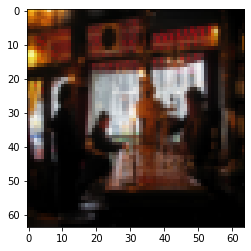

In [ ]:
print(train_set[94])
plt.imshow(train_set[94])

Instantiating the VAE model. More layers and smaller filters: we wanted to keep some granularity.  

In [ ]:
img_shape = (64, 64, 3)
batch_size = 16
latent_dim = 2  # Dimensionality of the latent space: a plane

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Creating the sampling function in order to cluster within the latent space. 

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [ ]:
# This is the input where we will feed `z`.
decoder_input = layers.Input(K.int_shape(z)[1:])

# Upsampling to the correct number of units
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# Reshaping into an image of the same shape as the last Flatten layer
x = layers.Reshape(shape_before_flattening[1:])(x)

# Reverse operation to the initial stack of convolution layers: 
#a `Conv2DTranspose` layer with the corresponding parameters.
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(3, 3,
                  padding='same', activation='sigmoid')(x)
# Feature map of the same size as the original input.
# Below, the decoder model 
decoder = Model(decoder_input, x)

# The decoder is applied to z in order to get the decoded z
z_decoded = decoder(z)

Below, we define the reconstruction loss (whose output we won't use, and the sampling loss). 

In [ ]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# We call our custom layer on the input and the decoded output,
# to obtain the final model output.
y = CustomVariationalLayer()([input_img, z_decoded])

In [ ]:
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

train_set = np.asarray(train_set)
vae.fit(x=train_set, y=None,
        shuffle=True,
        epochs=30,
        batch_size=batch_size,
        )


/usr/local/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 64)   36928       conv2d_2[0][0]                   
____________________________________________________________________________________________